<a href="https://colab.research.google.com/github/jan94z/rice_analysis_gee/blob/main/rice_analysis_gee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of a rice field in the Valencian Community using Google Earth Engine's Python API

Within a remote sensing course at the _Polytechnic University of Valencia_ we studied analyzing crops by using different GIS tools, such as _EO Browser_, _SNAP_, _QGIS_ and _Google Earth Engine_. 

The task of our final project was to analyze a given field of rice, located in the _Albufera Park_, in the course of one growing period, using one or more of these applications. The park is located just south of the city of Valencia and represents one of the most important rice growing regions of Europe.

To solve the task, I chose to use Google Earth Engine. The original solution was done in the JavaScript-based _Code Editor_. However, it left me curious about how the Python API works, which is the reason for this project here.

Everything was carried out in _Google Colab_. 

If you are interested in the rice cultivation cycle of the Valencian Community: https://doi.org/10.3390/rs13204095 .

In [1]:
%%capture
# install missing packages
!pip install geetools
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.5 MB/s eta 0:00:00
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92106 sha256=a3eba1907e412f04d2b907e6e595cceffe6a93ff12bf7ae634a80f86329fa62b
  Stored in directory: /root/.cache/pip/wheels/9b/fa/51/352ca759c01911b9b968195bcea49bd452f56acccbf0fa9b05
Successfully built geetools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 7.0 MB/s eta 0

In [2]:
import ee
import geetools
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
# Authenticate the access to Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=FUdptLQQgSgG9JeL8EqLBKtsu0H5JqbYG9Y5qvHJrIU&tc=dUWdKLuHJzh1mG5lICcmnkuTe3WHfnr7db7PygrknD4&cc=xiSgK4KkZPCF9II9gkxuM68Gmsgh4xrYdQVMg7b9yHg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh5M442kJCJe3tncuEm6Rwbu4BYwnEPhkuJdz_6Svwpdmpz3Ih9CI2w

Successfully saved authorization token.


In [4]:
# coordinates of the field of rice
field = ee.Geometry.Polygon(
        [[[-0.3832281488739442, 39.359508187098584],
          [-0.38298406785358896, 39.359484337985016],
          [-0.3825656432472657, 39.35943560281458],
          [-0.38235563488590474, 39.35943015163163],
          [-0.38222134354513715, 39.35980016770354],
          [-0.38208505246087876, 39.36016793089962],
          [-0.38194884217037206, 39.36053460298375],
          [-0.3818455771232987, 39.360818740618186],
          [-0.381762428643837, 39.36104167340761],
          [-0.38170744335903173, 39.36119617059777],
          [-0.3817181721950913, 39.361209650202184],
          [-0.381738288762703, 39.36122935115779],
          [-0.3817599771672153, 39.36123246183448],
          [-0.38273361903962133, 39.3614719835239],
          [-0.382753735607233, 39.361411489438844],
          [-0.3829119859391117, 39.36098428963761],
          [-0.383078282898035, 39.360611006119],
          [-0.38321239334877966, 39.36026156946189],
          [-0.3833532093220615, 39.359885360156824],
          [-0.383394229951195, 39.3597580197425],
          [-0.38345457965403007, 39.35953508285621]]])

# coordinates of wider area for displaying purposes
area = ee.Geometry.Polygon(
        [[[-0.39466116033436416, 39.3667866079925],
          [-0.39466116033436416, 39.353846023573496],
          [-0.37200185857655166, 39.353846023573496],
          [-0.37200185857655166, 39.3667866079925]]], None, False)

In [5]:
# clip the collection for faster processing
def clip_collection(roi):
  def clp(image):
    return image.clip(roi)
  return clp

# add a simplified date format for labeling
def add_date(image):
  return image.set('date', image.date().format('MM-dd'))

# calculate the NDVI
def add_ndvi(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return image.addBands(ndvi)

# calculate the mean of all bands for our field
def calc_mean(roi):
  def red(image):
   stats = image.reduceRegion(ee.Reducer.mean(), roi, 10)
   return image.set('stats', stats)
  return red

# get Sentinel-2 data
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# define boundaries
start = '2022-05-01' 
end = '2022-11-30'
bands = ['B2', 'B3', 'B4', 'B8']

# filter the complete Sentinel-2 collection execute calculations
collection = ee.ImageCollection((sentinel2) 
.filterBounds(field)
.filterMetadata('MGRS_TILE', 'equals' ,'30SYJ')
.filterDate(start, end) 
.select(bands)
.map(clip_collection(area))
.map(add_date)
.map(add_ndvi)
.map(calc_mean(field))
.sort('date')
)

collection

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [6]:
# display the region, the rice field, and the chosen wider area
Map = geemap.Map()
visparams = {'min': 0, 'max': 5000, 'gamma': 1.2, 'bands': ['B4', 'B3', 'B2']}

some_image = ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220510T104621_20220510T104859_T30SYJ')
Map.addLayer(some_image, visparams, 'Image')
Map.addLayer(area, {'color': 'efefef', 'opacity': 0.3}, 'Region of interest')
Map.addLayer(field, {'color': 'c5000a'}, 'Rice field')
Map.centerObject(area, 15)
Map

Map(center=[39.360316300531956, -0.3833315094465108], controls=(WidgetControl(options=['position', 'transparen…

In [7]:
# display all the available images to discard images where the field is covered by clouds or cloud shadows
image_list = collection.toList(100)
# the images will be displayed on several maps, as geemap does not handle so many images on one map that well 
def list_to_map(colAsList, roi, idx1, idx2, visparams):
  Map = geemap.Map()
  Map.centerObject(roi, 15)
  for idx in range(idx1, idx2):
    img = ee.Image(colAsList.get(idx))
    Map.addLayer(img, visparams, str(idx), 0)
  return Map

In [8]:
Map1 = list_to_map(image_list, area, 0, 10, visparams)
Map1

Map(center=[39.360316300531956, -0.3833315094465108], controls=(WidgetControl(options=['position', 'transparen…

In [9]:
Map2 = list_to_map(image_list, area, 10, 20, visparams)
Map2

Map(center=[39.360316300531956, -0.3833315094465108], controls=(WidgetControl(options=['position', 'transparen…

In [10]:
Map3 = list_to_map(image_list, area, 20, 31, visparams)
Map3

Map(center=[39.360316300531956, -0.3833315094465108], controls=(WidgetControl(options=['position', 'transparen…

In [11]:
Map4 = list_to_map(image_list, area, 31, 42, visparams)
Map4

Map(center=[39.360316300531956, -0.3833315094465108], controls=(WidgetControl(options=['position', 'transparen…

In [12]:
# the images to dicard have been chosen manually
images_to_discard = [8, 20, 26, 27, 28, 31, 33, 38, 39, 40, 41]

# convert the data that we want to use into a pandas dataframe
dates = collection.aggregate_array('date')
stats = collection.aggregate_array('stats')
data = ee.FeatureCollection([ee.Feature(None, {'date': dates, 'stats': stats})])
df = geemap.ee_to_pandas(data)
for s, d in zip(df['stats'], df['date']):
  new_df = pd.DataFrame(s)
  new_df['date'] = d

# reflectance values in GEE are in a range from 0 to 10000 by default -> change it to a values between 0 and 1
new_df[['B2', 'B3', 'B4', 'B8']] /= 10000

# instead of dropping the images I prefer to set the values to NaN, so that we can later display the missing dates in the graphs
new_df.loc[images_to_discard, ['B2', 'B3', 'B4', 'B8', 'NDVI']] = None
display(new_df)

,B2,B3,B4,B8,NDVI,date
0,0.110617,0.157381,0.152421,0.237734,0.218731,05-05
1,0.100042,0.144981,0.154414,0.213291,0.160144,05-10
2,0.159564,0.198624,0.226219,0.271534,0.091809,05-15
3,0.104523,0.139156,0.173485,0.222141,0.123055,05-20
4,0.133126,0.158628,0.199599,0.261288,0.133885,05-25
5,0.134222,0.169804,0.209772,0.259032,0.105143,05-30
6,0.133140,0.163817,0.204587,0.253994,0.107851,06-04
7,0.139662,0.176825,0.218757,0.257848,0.082767,06-09
8,NaN,NaN,NaN,NaN,NaN,06-14
9,0.066044,0.102702,0.092248,0.146770,0.229729,06-19


In [13]:
def connect_missing_points(x1, y1, x2, y2, **kwargs):
  x = [x1, x2]
  y = [y1, y2]
  plt.plot(x, y, **kwargs)

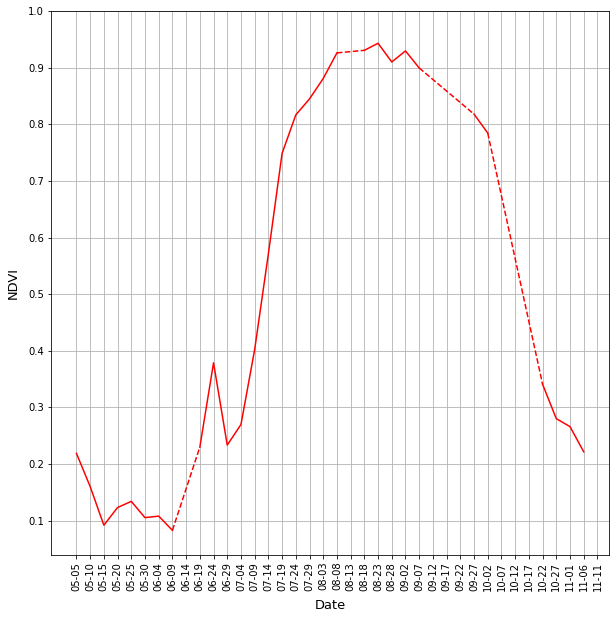

In [14]:
plt.figure(figsize=(10,10))
plt.plot(new_df['date'], new_df['NDVI'], color='red')
connect_missing_points(new_df.loc[7, 'date'], new_df.loc[7, 'NDVI'], new_df.loc[9, 'date'], new_df.loc[9, 'NDVI'], color='red', linestyle='--')
connect_missing_points(new_df.loc[19, 'date'], new_df.loc[19, 'NDVI'], new_df.loc[21, 'date'], new_df.loc[21, 'NDVI'], color='red', linestyle='--')
connect_missing_points(new_df.loc[25, 'date'], new_df.loc[25, 'NDVI'], new_df.loc[29, 'date'], new_df.loc[29, 'NDVI'], color='red', linestyle='--')
connect_missing_points(new_df.loc[30, 'date'], new_df.loc[30, 'NDVI'], new_df.loc[34, 'date'], new_df.loc[34, 'NDVI'], color='red', linestyle='--')
plt.plot()
plt.xlabel('Date', fontsize=13, labelpad=8)
plt.xticks(rotation=90)
plt.ylabel('NDVI', labelpad=8, fontsize=13)
plt.yticks([x/10 for x in range(1, 11)])
plt.grid()
plt.show()

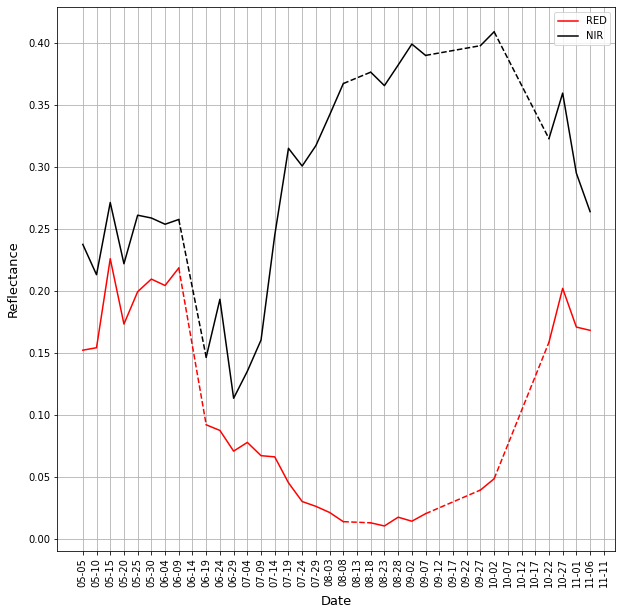

In [15]:
plt.figure(figsize=(10,10))
plt.plot(new_df['date'], new_df['B4'], label='RED', color='red')
plt.plot(new_df['date'], new_df['B8'], label='NIR', color='black')
connect_missing_points(new_df.loc[7, 'date'], new_df.loc[7, 'B4'], new_df.loc[9, 'date'], new_df.loc[9, 'B4'], color='red', linestyle='--')
connect_missing_points(new_df.loc[19, 'date'], new_df.loc[19, 'B4'], new_df.loc[21, 'date'], new_df.loc[21, 'B4'], color='red', linestyle='--')
connect_missing_points(new_df.loc[25, 'date'], new_df.loc[25, 'B4'], new_df.loc[29, 'date'], new_df.loc[29, 'B4'], color='red', linestyle='--')
connect_missing_points(new_df.loc[30, 'date'], new_df.loc[30, 'B4'], new_df.loc[34, 'date'], new_df.loc[34, 'B4'], color='red', linestyle='--')
connect_missing_points(new_df.loc[7, 'date'], new_df.loc[7, 'B8'], new_df.loc[9, 'date'], new_df.loc[9, 'B8'], color='black', linestyle='--')
connect_missing_points(new_df.loc[19, 'date'], new_df.loc[19, 'B8'], new_df.loc[21, 'date'], new_df.loc[21, 'B8'], color='black', linestyle='--')
connect_missing_points(new_df.loc[25, 'date'], new_df.loc[25, 'B8'], new_df.loc[29, 'date'], new_df.loc[29, 'B8'], color='black', linestyle='--')
connect_missing_points(new_df.loc[30, 'date'], new_df.loc[30, 'B8'], new_df.loc[34, 'date'], new_df.loc[34, 'B8'], color='black', linestyle='--')
plt.xlabel('Date', labelpad=8, fontsize=13)
plt.xticks(rotation=90)
plt.ylabel('Reflectance', labelpad=8, fontsize=13)
plt.legend()
plt.grid()
plt.show()

In [16]:
# randomly assign 30 points within the field for further analysis
points = ee.FeatureCollection.randomPoints(field, 30, 1)
size = collection.size().getInfo()

first = True
for idx in range(size):
  if idx not in images_to_discard:
    image = ee.Image(image_list.get(idx))
    ft = image.sampleRegions(points, scale=10) # get the band values of the 30 sample points
    point_df = geemap.ee_to_pandas(ft)
    if first:
      b3points = pd.DataFrame({new_df.loc[idx, 'date']: point_df['B3']})
      b4points = pd.DataFrame({new_df.loc[idx, 'date']: point_df['B4']})
      b8points = pd.DataFrame({new_df.loc[idx, 'date']: point_df['B8']})
      first = False
    else:
      b3points[new_df.loc[idx, 'date']] = point_df['B3']
      b4points[new_df.loc[idx, 'date']] = point_df['B4']
      b8points[new_df.loc[idx, 'date']] = point_df['B8']

b3points /= 10000
b4points /= 10000
b8points /= 10000

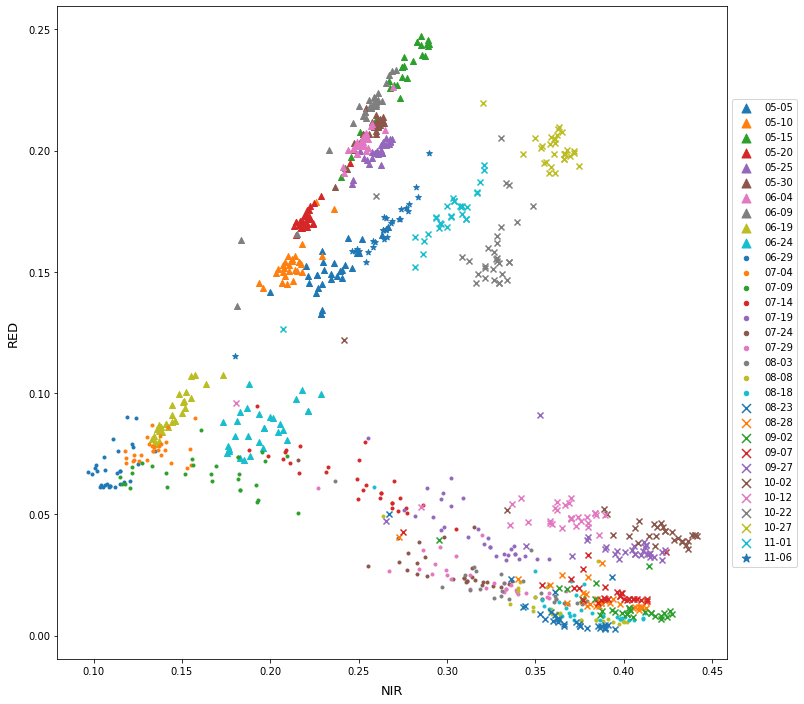

In [17]:
plt.figure(figsize=(12,12))

for date in b4points.iloc[:,:10]:
  plt.scatter(b8points[date], b4points[date], label=date, marker="^", linewidths=1)
for date in b4points.iloc[:,10:20]:
  plt.scatter(b8points[date], b4points[date], label=date, marker=".", linewidths=1)
for date in b4points.iloc[:,20:30]:
  plt.scatter(b8points[date], b4points[date], label=date, marker="x", linewidths=1)
for date in b4points.iloc[:,30:]:
  plt.scatter(b8points[date], b4points[date], label=date, marker="*", linewidths=1)

plt.ylabel('RED', labelpad=8, fontsize=13)
plt.xlabel('NIR', labelpad=8, fontsize=13)
plt.legend(loc ='center right', borderaxespad=-7, markerscale=1.5)
plt.show()

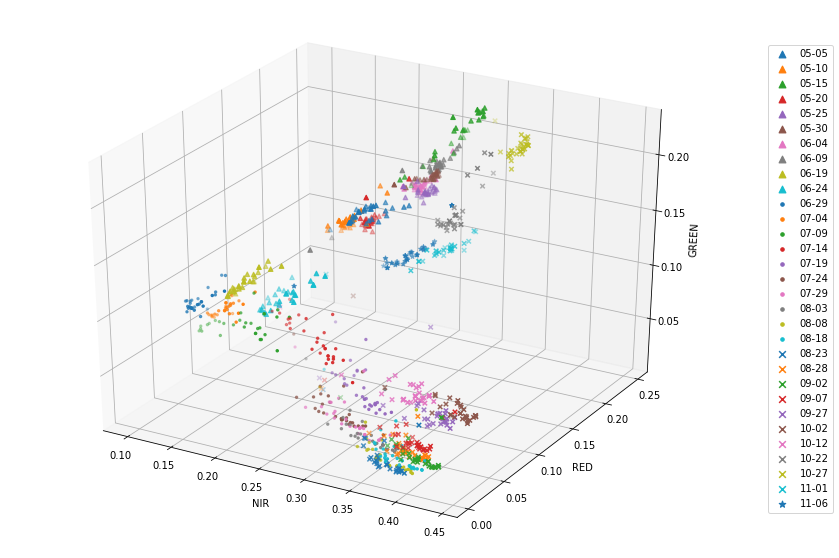

In [18]:
fig = plt.figure(figsize = (13, 10))
ax = plt.axes(projection ="3d")
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

for date in b4points.iloc[:,:10]:
  ax.scatter3D(b8points[date], b4points[date], b3points[date], label=date, marker="^", linewidths=1.2)
for date in b4points.iloc[:,10:20]:
  ax.scatter3D(b8points[date], b4points[date], b3points[date], label=date, marker=".", linewidths=1.2)
for date in b4points.iloc[:,20:30]:
  ax.scatter3D(b8points[date], b4points[date], b3points[date], label=date, marker="x", linewidths=1.2)
for date in b4points.iloc[:,30:]:
  ax.scatter3D(b8points[date], b4points[date], b3points[date], label=date, marker="*", linewidths=1.2)

ax.set_xlabel('NIR')
ax.set_ylabel('RED')
ax.set_zlabel('GREEN')
plt.legend(loc ='center right', borderaxespad=-10, markerscale=1.5)
plt.show()